In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.metrics import roc_curve, auc




In [2]:
clean_data = pd.read_csv('data/clean_data.tsv', sep='\t', encoding='utf-8')
clean_data = clean_data.astype(str)
print('Total records:', len(clean_data))

Total records: 72080


In [3]:
clean_data.head()

,URBAN-Rural status,Household wealth index in quintiles,Highest educational level,Final say on woman's health care,Unmet need for FP,Whether and when this child's pregnancy wanted,Sex of child,Current age of child in years,Age of child in months,Weight for height percentile (CDC standards),...,Child given nothing as treatment for diarrhea,Child received oral polio 0 vaccination,Child received oral polio 1 vaccination,Child received oral polio 2 vaccination,Year child received oral polio 3 vaccination,"Child received DPT (diphtheria, pertussis, tetanus) 1 vaccination","Child received DPT (diphtheria, pertussis, tetanus) 2 vaccination","Child received DPT (diphtheria, pertussis, tetanus) 3 vaccination",Child received measles (or measles containing) 1 vaccination,Child received BCG (TB) vaccination
0,Urban,Richest,Richest,Husband/partner,Husband/partner,Husband/partner,Male,NIU,NIU,NIU,...,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU
1,Urban,Richest,Richest,Husband/partner,Husband/partner,Husband/partner,Male,NIU,NIU,NIU,...,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU
2,Urban,Richest,Primary,NIU,NIU,NIU,Male,NIU,NIU,NIU,...,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU
3,Urban,Richest,Secondary,Secondary,Secondary,Secondary,Male,NIU,NIU,NIU,...,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU
4,Urban,Richest,Richest,Husband/partner,Husband/partner,Husband/partner,Female,NIU,NIU,NIU,...,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU,NIU


In [4]:
y = np.load('data/labels.npy')

In [5]:
X = np.array(clean_data)
print('Total Records: ', X.shape[0])
print('Total Variables/Attributes: ', X.shape[1])

Total Records:  72080
Total Variables/Attributes:  54


In [6]:
for i in range (X.shape[1]):
    le = LabelEncoder()
    X[:,i] = le.fit_transform(X[:,i])



In [7]:
le_y = LabelEncoder()
y = le.fit_transform(y)  



In [8]:
y = label_binarize(y, classes=np.unique(y))

nbr_classes = y.shape[1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [10]:
from keras.layers import Dense, Input, BatchNormalization, Dropout, Reshape, Conv1D, GlobalMaxPool1D, concatenate
from keras.models import Model
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,  ReduceLROnPlateau, CSVLogger




ip = Input(shape=(X.shape[1],))
x = Reshape((-1,X.shape[1]))(ip)

x = Conv1D(filters=128,kernel_size=2,padding='causal',activation='relu',strides=1)(x)
x = GlobalMaxPool1D()(x)


x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)



out = Dense(nbr_classes, activation='softmax') (x)
model = Model(inputs=[ip], outputs=[out])

optimizer = optimizers.Adam(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Using TensorFlow backend.


In [12]:
logCallback = CSVLogger('logs/train_log_CNN_only.csv', separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=0, mode='max')
checkpoint = ModelCheckpoint('models/CNN.h5', monitor='val_acc', save_weights_only=True, verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]

In [13]:
model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
                       batch_size=256,
                       epochs=200,
                       verbose=2,
                       shuffle=True,
                       #class_weight = class_weights,
                       callbacks=callbacks_list)

Train on 54060 samples, validate on 18020 samples
Epoch 1/200
 - 4s - loss: 2.0939 - acc: 0.5460 - val_loss: 2.9455 - val_acc: 0.5266

Epoch 00001: val_acc improved from -inf to 0.52658, saving model to models/CNN.h5
Epoch 2/200
 - 1s - loss: 1.7182 - acc: 0.5944 - val_loss: 1.6476 - val_acc: 0.6090

Epoch 00002: val_acc improved from 0.52658 to 0.60899, saving model to models/CNN.h5
Epoch 3/200
 - 1s - loss: 1.6785 - acc: 0.5999 - val_loss: 2.1526 - val_acc: 0.3789

Epoch 00003: val_acc did not improve from 0.60899
Epoch 4/200
 - 1s - loss: 1.6378 - acc: 0.6115 - val_loss: 2.0355 - val_acc: 0.5887

Epoch 00004: val_acc did not improve from 0.60899
Epoch 5/200
 - 1s - loss: 1.6139 - acc: 0.6180 - val_loss: 1.5418 - val_acc: 0.6318

Epoch 00005: val_acc improved from 0.60899 to 0.63180, saving model to models/CNN.h5
Epoch 6/200
 - 1s - loss: 1.6062 - acc: 0.6186 - val_loss: 1.5159 - val_acc: 0.6553

Epoch 00006: val_acc improved from 0.63180 to 0.65527, saving model to models/CNN.h5
Epo

In [11]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score


In [12]:
model.load_weights('models/CNN.h5')

In [13]:
y_pred = model.predict(X_test)

In [14]:
label_pred = np.argmax(y_pred, 1)
label_test = np.argmax(y_test, 1)

In [15]:
print('Testing Accuracy: ',accuracy_score(label_pred, label_test))

Testing Accuracy:  0.6595449500554939


In [16]:
print('F1-score Macro Average: ', f1_score(label_test, label_pred, average='macro'))
print('F1-score Micro Average: ', f1_score(label_test, label_pred, average='micro'))
print('F1-score Weighted Average: ', f1_score(label_test, label_pred, average='weighted'))




F1-score Macro Average:  0.12476466336337062
F1-score Micro Average:  0.6595449500554939
F1-score Weighted Average:  0.599359454044748


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

           0       0.72      0.99      0.83      8392
           1       0.65      0.57      0.61      1017
           2       0.00      0.00      0.00       244
           3       0.00      0.00      0.00       240
           4       0.46      0.55      0.50       947
           5       0.00      0.00      0.00       194
           6       0.00      0.00      0.00       155
           7       0.00      0.00      0.00       115
           8       0.00      0.00      0.00        92
           9       0.00      0.00      0.00        71
          10       0.00      0.00      0.00       250
          11       0.00      0.00      0.00        50
          12       0.37      0.38      0.37       767
          13       0.00      0.00      0.00        66
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        36
          16       0.00      0.00      0.00        35
          17       0.43    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Compute FPR TPR

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nbr_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [19]:
# Compute micro-average ROC and Area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [20]:
# Compute macro-average ROC and Area

# Aggregate all False Positive Rates
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nbr_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(nbr_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= nbr_classes
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# Plot Time

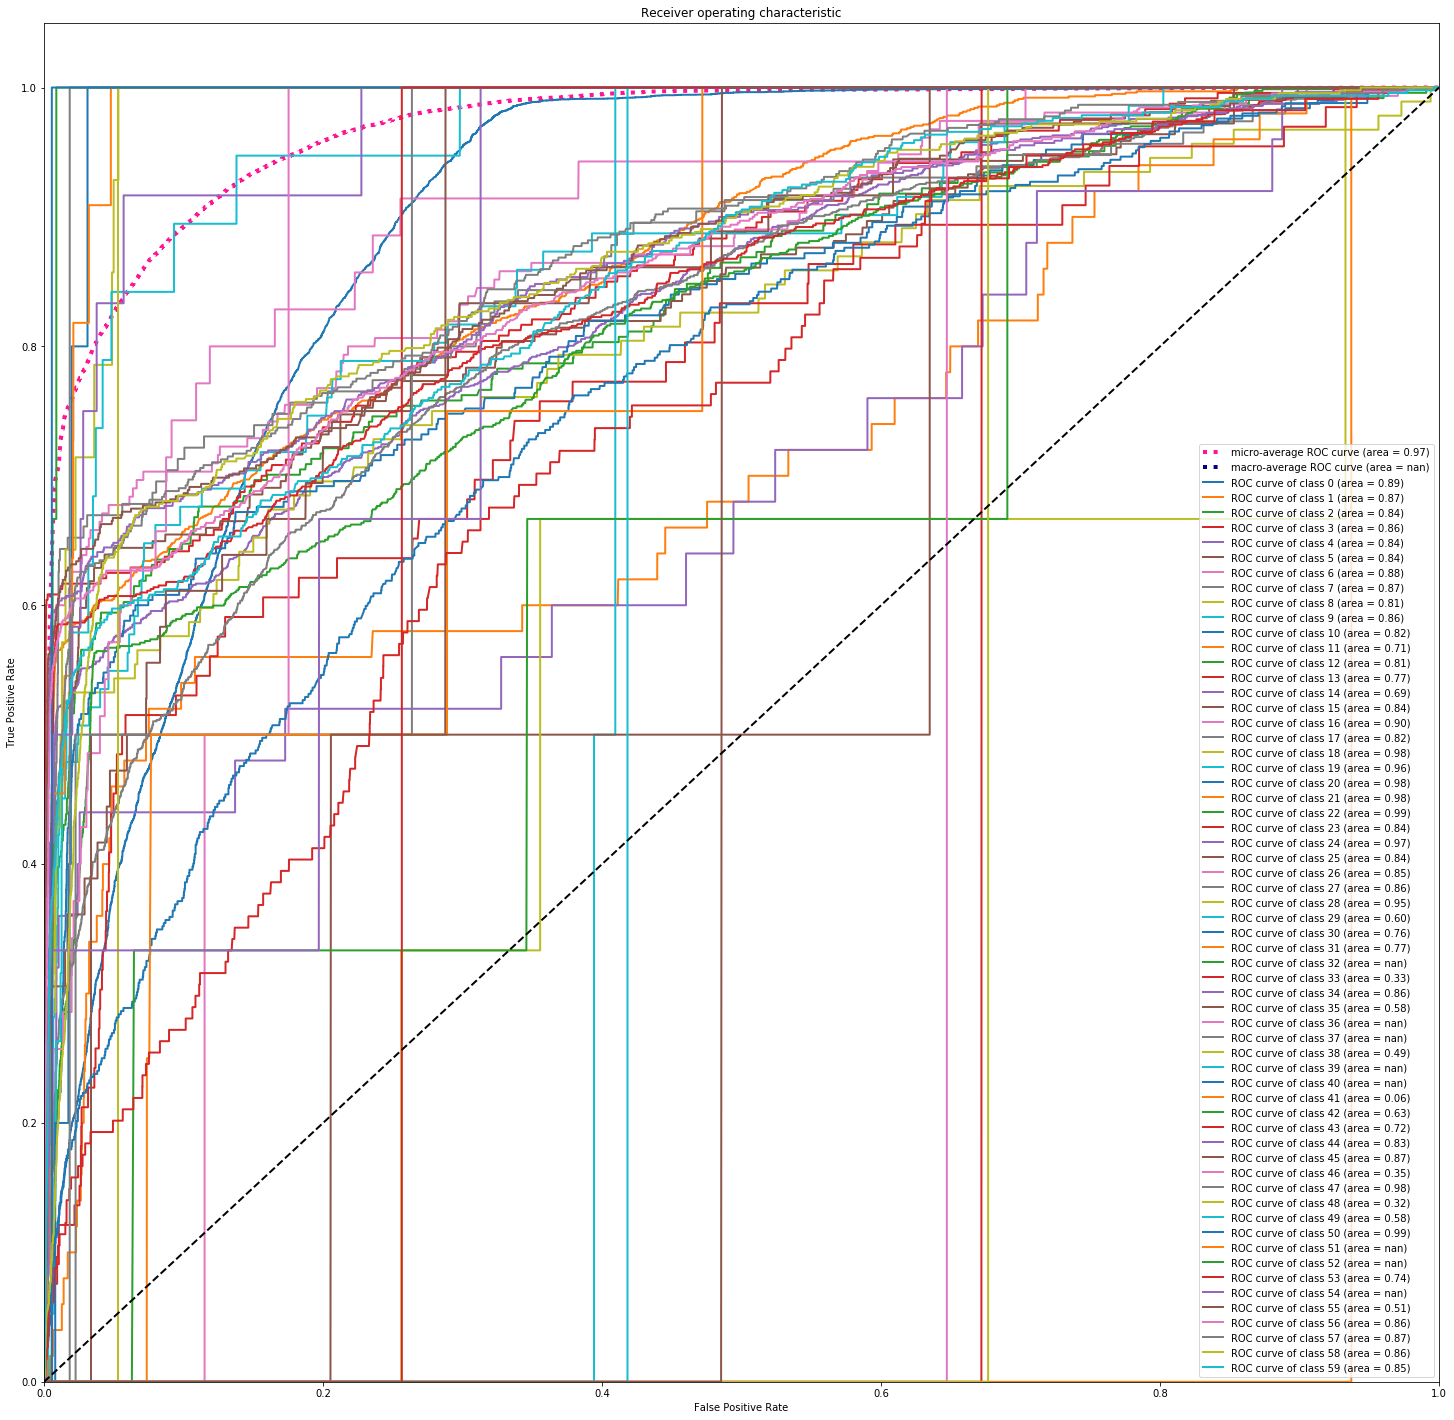

In [21]:
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline
lw = 2
plt.figure(figsize = (25,25))
plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nbr_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot macro AUC

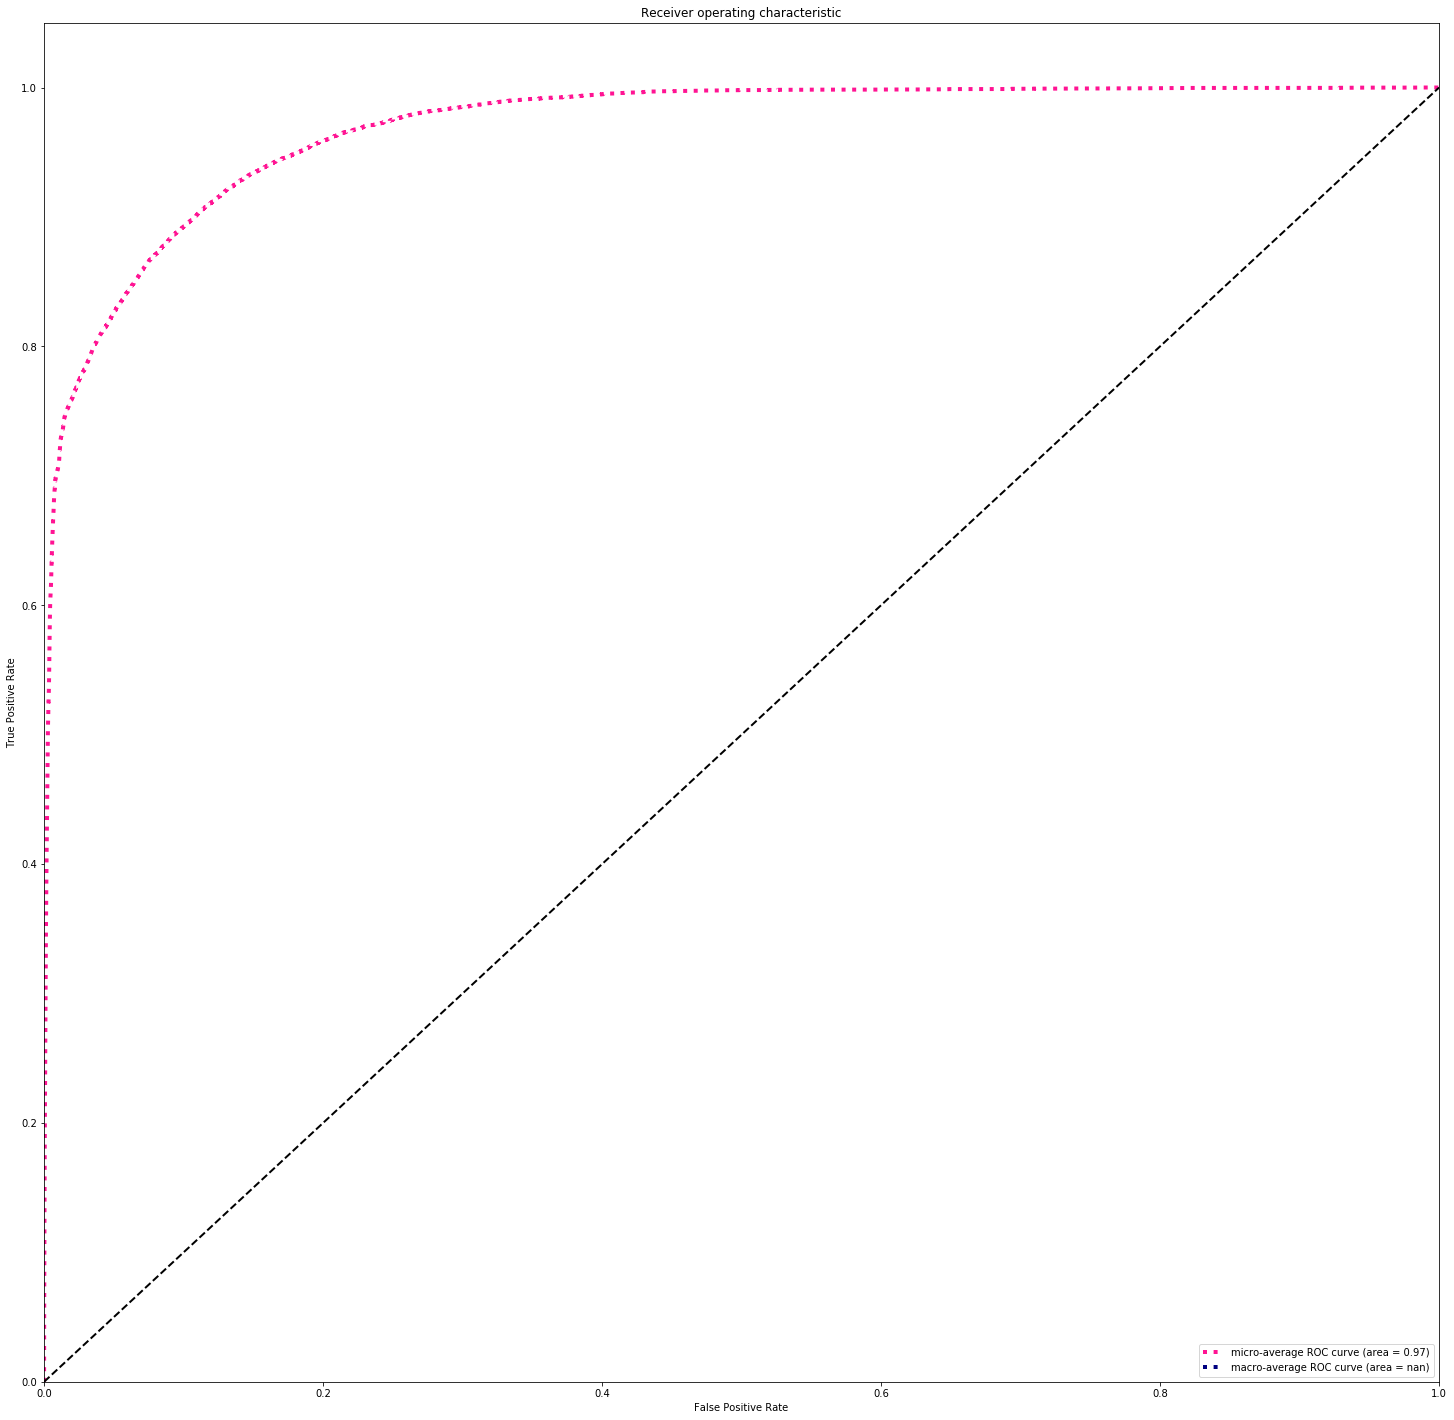

In [22]:
import matplotlib.pyplot as plt
from itertools import cycle
lw = 2
plt.figure(figsize = (25,25))
plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save micro average values for plotting later

import pickle

outfile = open('fpr_bin_cnn.pickle','wb')
pickle.dump(fpr,outfile)
outfile.close()

outfile = open('tpr_bin_cnn.pickle','wb')
pickle.dump(tpr,outfile)
outfile.close()

outfile = open('rocauc_cnn.pickle','wb')
pickle.dump(roc_auc,outfile)
outfile.close()

# Calculate specifitivity and sensitivity through confusion matrix

In [27]:
cm = confusion_matrix(label_test, label_pred)

In [28]:
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

In [29]:
# Recall, Sensitivity, Hit Rate, TPR

tpr = tp/(tp+fn)

In [30]:
print('TPR/Sensitivity for each class', tpr)

TPR/Sensitivity for each class [0.98581983 0.57423795 0.         0.         0.55332629 0.
 0.         0.         0.         0.         0.         0.
 0.37548892 0.         0.         0.         0.         0.35507246
 0.         0.         0.         0.         0.         0.58526603
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60892857 0.         0.
 0.         0.         0.         0.         0.20813397 0.
 0.         0.         0.         0.         0.         0.
 0.58218126 0.57238307 0.32603939 0.49464668]


In [31]:
# Specifitivity, TNR

tnr = tn/(tn+fp)

In [32]:
print('TNR/Specifitivity', tnr)

TNR/Specifitivity [0.66140424 0.98176792 1.         1.         0.96444679 1.
 1.         1.         1.         1.         1.         1.
 0.97119342 1.         1.         1.         1.         0.97308549
 1.         1.         1.         1.         1.         0.98802568
 1.         1.         1.         1.         1.         1.
 0.99994321 1.         1.         0.9847079  1.         1.
 1.         1.         1.         1.         0.9985229  1.
 1.         1.         1.         1.         1.         1.
 0.99044274 0.99146321 0.99521722 0.994246  ]
